# CS 4476 Project 1: Image Filtering and Hybrid Images

All projects in this course will be done with these iPython notebooks. These are convenient ways for you to quickly and easily interact with the code. A notebook contains many blocks of code, each of which can be run independently. You can run a cell with ctrl+enter or shift+enter (to move to the next cell).


## Part 1: NumPy
### Setup

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


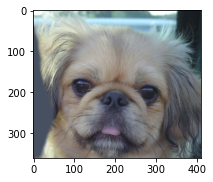

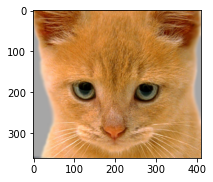

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from utils import load_image, save_image

%matplotlib inline
%load_ext autoreload
%autoreload 2


image1 = load_image('../data/1a_dog.bmp')
image2 = load_image('../data/1b_cat.bmp')

# display the dog and cat images
plt.figure(figsize=(3,3)); plt.imshow((image1*255).astype(np.uint8));
plt.figure(figsize=(3,3)); plt.imshow((image2*255).astype(np.uint8));

### Create filter

You will first need to implement `create_Gaussian_kernel()` in `part1.py`.

Success -- kernel values are correct.
True


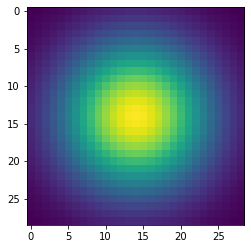

In [5]:
from part1 import my_imfilter, create_hybrid_image, create_Gaussian_kernel
import sys 
sys.path.append("../tests") 
from unit_test import verify_gaussian_kernel

cutoff_frequency = 7
kernel = create_Gaussian_kernel(cutoff_frequency)

# let's take a look at the filter!
plt.figure(figsize=(4,4)); plt.imshow(kernel);

## Verify that the Gaussian kernel was created correctly
print(verify_gaussian_kernel(kernel, cutoff_frequency))

### Apply filter to image
The next two functions you need to implement in this project can also be found in `part1.py`. Start by implementing `my_imfilter`, which takes both a filter and an image, and returns the filtered image. This code block will use your `my_imfilter` function to create and display a blurry version of image1.

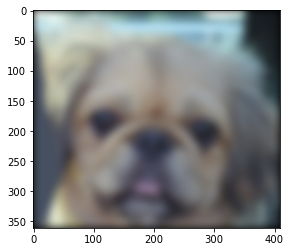

In [6]:
blurry_image = my_imfilter(image1, kernel)

plt.figure(); plt.imshow((blurry_image*255).astype(np.uint8));

### Create hybrid image
Next, implement _create_\__hybrid_\__image_(), which takes two images and makes a hybrid image using the low frequency content from one image and the high frequency content from another by applying the Gaussian kernel you defined in `create_Gaussian_kernel()`.

Experiment with the value of `cutoff_frequency` for each pair of images in `data/`. For each image pair, replace `cutoff_frequencies.txt` with the best cutoff frequency value you find. The value on line *i* of the text file should correspond to _i_-th image pair. This is an important step for Part 2! Feel free to also experiment with which image in each pair you grab the low frequencies from and which image you grab high frequencies from.

In [7]:
from utils import vis_image_scales_numpy
import sys 
sys.path.append("../tests") 
from unit_test import (
    verify_low_freq_sq_kernel_np,
    verify_high_freq_sq_kernel_np,
    verify_hybrid_image_np
)
low_frequencies, high_frequencies, hybrid_image = create_hybrid_image(image1, image2, kernel)

## Verify that results are as expected
print(verify_low_freq_sq_kernel_np(image1, kernel, low_frequencies))
print(verify_high_freq_sq_kernel_np(image2, kernel, high_frequencies))
print(verify_hybrid_image_np(image1, image2, kernel, hybrid_image))

vis = vis_image_scales_numpy(hybrid_image)

Success! Low frequencies values are correct.
True
Success! High frequencies values are correct.
True
Success! Hybrid image values are correct.
True


### Show results

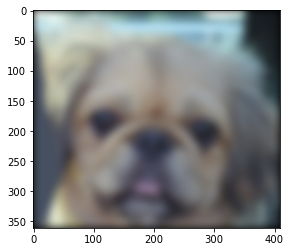

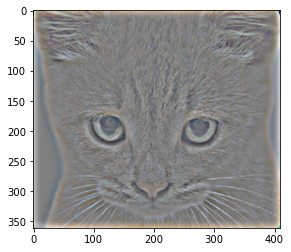

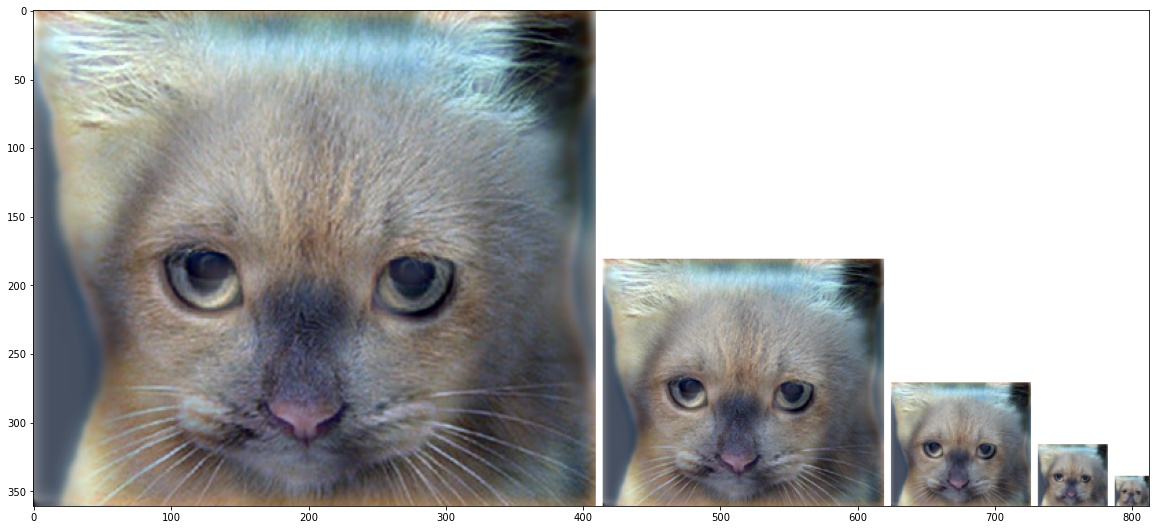

In [8]:
plt.figure(); plt.imshow((low_frequencies*255).astype(np.uint8));
plt.figure(); plt.imshow(((high_frequencies+0.5)*255).astype(np.uint8));
plt.figure(figsize=(20, 20)); plt.imshow(vis);

### Save results

In [9]:
save_image('../results/part1/low_frequencies.jpg', low_frequencies)
save_image('../results/part1/high_frequencies.jpg', high_frequencies+0.5)
save_image('../results/part1/hybrid_image.jpg', hybrid_image)
save_image('../results/part1/hybrid_image_scales.jpg', vis)

## Part 2: PyTorch 

Make sure you have specified a cutoff value in `cutoff_frequencies.txt` for each image pair in `data/` before executing the following blocks.

In [10]:
import torch
import torchvision

from datasets import HybridImageDataset
from models import HybridImageModel


data_root = '../data' # if you're using additional data, make sure to change this to '../additional_data'
cf_file = '../cutoff_frequencies.txt'

### Instantiate model & dataset
Implement `HybridImageModel` and `HybridImageDataset`, found in `models.py` and `datasets.py`, respectively.

In the code documentation, you will see a term called "batch size", which we will discuss in later projects and lectures. For now, we are using the default value of 1. 

In [11]:
model = HybridImageModel()
dataset = HybridImageDataset(data_root, cf_file)
dataloader = torch.utils.data.DataLoader(dataset)

data_iter = iter(dataloader)

### Create hybrid images
This code block will iterate through pairs of images from your dataset and create a hybrid image using the low frequency content from one image and the high frequency content from another.

In [12]:
for i in range(len(dataset)):
    image_a, image_b, cutoff_frequency = next(data_iter)
    low_frequencies, high_frequencies, hybrid_image = model(image_a, image_b, cutoff_frequency)
    
    # saves low frequencies, high frequencies, and hybrid image of each pair of images
    torchvision.utils.save_image(low_frequencies, '../results/part2/%d_low_frequencies.jpg' % i)
    torchvision.utils.save_image(high_frequencies+0.5, '../results/part2/%d_high_frequencies.jpg' % i)
    torchvision.utils.save_image(hybrid_image, '../results/part2/%d_hybrid_image.jpg' % i)

In [13]:
## Verify that the results are correct, with cutoff_frequency of 7
import sys 
sys.path.append("../tests") 
from unit_test import (
    verify_low_freq_sq_kernel_pytorch, 
    verify_high_freq_sq_kernel_pytorch,
    verify_hybrid_image_pytorch
)

dataset = HybridImageDataset(data_root, cf_file)
dataloader = torch.utils.data.DataLoader(dataset)
image_a, image_b, cutoff_frequency = next(iter(dataloader))

# a, b, c, d = hybrid_image.shape
# h = hybrid_image.view(b, c, d)
# plt.imshow(h.permute(1, 2, 0))

low_frequencies, high_frequencies, hybrid_image = model(image_a, image_b, cutoff_frequency)

cutoff_freq = torch.Tensor([7])
## On first dog/cat pair, verify that the Pytorch results are as expected
print(verify_low_freq_sq_kernel_pytorch(image_a, model, cutoff_freq, low_frequencies))
print(verify_high_freq_sq_kernel_pytorch(image_b, model, cutoff_freq, high_frequencies))
## Verify that the Pytorch hybrid images are created correctly
print(verify_hybrid_image_pytorch(image_a, image_b, model, cutoff_freq, hybrid_image))

Success! Pytorch low frequencies values are correct.
True
Success! Pytorch high frequencies values are correct.
True
Success! Pytorch hybrid image values are correct.
True


### Hybrid image timing comparison
Here, we will compare the runtime of creating hybrid images using your NumPy implementation to using your PyTorch implementation.

In [14]:
import time


image1 = load_image('../data/1a_dog.bmp')
image2 = load_image('../data/1b_cat.bmp')

Timing Part 1. Notice that we explicitly include `create_Gaussian_kernel()` in the timing of Part 1 but not Part 2. This is because the function is already being called (and therefore timed) inside the forward pass of `HybridImageModel`.

In [15]:
start = time.time()
cutoff_frequency = 7
kernel = create_Gaussian_kernel(cutoff_frequency)
low_frequencies, high_frequencies, hybrid_image = create_hybrid_image(image1, image2, kernel)
end = time.time() - start
print('Part 1: {:.3f} seconds'.format(end))

Part 1: 9.243 seconds


Timing Part 2

In [16]:
model = HybridImageModel()

start = time.time()

low_frequencies, high_frequencies, hybrid_image = model(image_a, image_b, torch.Tensor([cutoff_frequency]))


end = time.time() - start
print('Part 2: {:.3f} seconds'.format(end))

Part 2: 0.208 seconds
